In [ ]:
#----------------------------------------------------------------------
#     import packages
#----------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_curve,roc_auc_score,auc, f1_score

from sklearn import neighbors
from sklearn import ensemble
from sklearn import impute
from sklearn import model_selection
imp = impute.SimpleImputer(missing_values=np.nan,strategy="most_frequent")

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn import tree
import re

In [3]:
#----------------------------------------------------------------------
#     clean data
#----------------------------------------------------------------------

data_restaurant=pd.read_csv('restaurant.csv',encoding='utf-16',sep='\t')
data_member=pd.read_csv('member.csv',encoding='utf-16',sep='\t')
data_Train=pd.read_csv('Train.csv',encoding='utf-8',sep=',')
data_Test=pd.read_csv('Test.csv',encoding='utf-8',sep=',')

#example=pd.read_csv('submission_example.csv',encoding='utf-8',sep=',')

#clean nan
data_restaurant_clean=imp.fit_transform(data_restaurant)
data_Train_clean=imp.fit_transform(data_Train)
data_Test_clean=imp.fit_transform(data_Test)

In [4]:
#----------------------------------------------------------------------
#     create clean file 
#----------------------------------------------------------------------
data_restaurant_clean=pd.DataFrame(data_restaurant_clean,columns=data_restaurant.columns.values)
data_Train_clean=pd.DataFrame(data_Train_clean,columns=data_Train.columns.values)
data_Test_clean=pd.DataFrame(data_Test_clean,columns=data_Test.columns.values)

data_restaurant_clean.to_csv('data_restaurant_clean.csv',encoding='utf-16',sep='\t')
data_Train_clean.to_csv('data_Train_clean.csv',encoding='utf-8',sep=',')
data_Test_clean.to_csv('data_Test_clean.csv',encoding='utf-8',sep=',')

In [5]:
#----------------------------------------------------------------------
#     import data clean
#----------------------------------------------------------------------
data_restaurant=pd.read_csv('data_restaurant_clean.csv',encoding='utf-16',sep='\t')
data_member=pd.read_csv('member.csv',encoding='utf-16',sep='\t')
data_Train=pd.read_csv('data_Train_clean.csv',encoding='utf-8',sep=',')
data_Test=pd.read_csv('data_Test_clean.csv',encoding='utf-8',sep=',')

data_restaurant=data_restaurant.drop(columns=["Unnamed: 0"])
data_Train=data_Train.drop(columns=['Unnamed: 0'],axis=1)
data_Test=data_Test.drop(columns=['Unnamed: 0'],axis=1)

In [6]:
#----------------------------------------------------------------------
#     data merge train/test and clean
#----------------------------------------------------------------------
data_Train['isTest']=0
data_Test['isTest']=1

dataset=data_Train.append(data_Test, sort=False)

dataset=dataset.sort_values(by='booking_id')
dataset.head()

,booking_id,member_id,cdate,restaurant_id,datetime,people,purpose,gender,status,is_required_prepay_satisfied,return90,isTest
0,1,000036888f8cf9f0b9f931dee1536c6997bbbd27,"7/24/2013,,11:30:00,PM",f3837c4489cc6c4587dfb8a92a060585c182ccc1,"8/8/2013,,7:00:00,PM",5,Repas en famille,F,ok,1,NaN,1
34861,7,000462cdd95e750a50cd664021e037a5b471f5e2,"6/8/2013,,2:03:00,AM",7c0079d1f506b211d53c00694577415061d78435,"6/9/2013,,6:00:00,PM",9,Dîner entre amis,M,ok,1,0.0,0
12732,8,00049d1d216aa9674616749029571fecd453a42d,"10/8/2012,,11:44:00,AM",7d818d2829ca905756e1d6b92efc07f904ef58a7,"10/19/2012,,6:30:00,PM",2,Sweet day,M,ok,1,0.0,0
1,12,0005612efb88671ddcb49ae213e7fd5e03a48989,"1/22/2014,,7:59:00,PM",e4b42c8e937bf0cdb01e4b90366358b70d5938ce,"1/24/2014,,6:30:00,PM",2,Fête d'anniversaire,F,ok,1,NaN,1
37675,13,0006018a813099f8e12c6e6c369c4efe90528f5c,"3/29/2014,,2:56:00,PM",c5e3325051eab0d50ad2544e617d9a74ce433b2c,"3/29/2014,,5:30:00,PM",4,Fête d'anniversaire,M,ok,1,1.0,0


In [7]:
#----------------------------------------------------------------------
#     clean merge train/test and clean
#----------------------------------------------------------------------
dataset_clean= pd.DataFrame(imp.fit_transform(dataset),columns=dataset.columns.values)
print(dataset_clean.shape)
print(dataset_clean.info())
dataset_clean.head()

(116974, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116974 entries, 0 to 116973
Data columns (total 12 columns):
booking_id                      116974 non-null object
member_id                       116974 non-null object
cdate                           116974 non-null object
restaurant_id                   116974 non-null object
datetime                        116974 non-null object
people                          116974 non-null object
purpose                         116974 non-null object
gender                          116974 non-null object
status                          116974 non-null object
is_required_prepay_satisfied    116974 non-null object
return90                        116974 non-null object
isTest                          116974 non-null object
dtypes: object(12)
memory usage: 10.7+ MB
None


,booking_id,member_id,cdate,restaurant_id,datetime,people,purpose,gender,status,is_required_prepay_satisfied,return90,isTest
0,1,000036888f8cf9f0b9f931dee1536c6997bbbd27,"7/24/2013,,11:30:00,PM",f3837c4489cc6c4587dfb8a92a060585c182ccc1,"8/8/2013,,7:00:00,PM",5,Repas en famille,F,ok,1,0,1
1,7,000462cdd95e750a50cd664021e037a5b471f5e2,"6/8/2013,,2:03:00,AM",7c0079d1f506b211d53c00694577415061d78435,"6/9/2013,,6:00:00,PM",9,Dîner entre amis,M,ok,1,0,0
2,8,00049d1d216aa9674616749029571fecd453a42d,"10/8/2012,,11:44:00,AM",7d818d2829ca905756e1d6b92efc07f904ef58a7,"10/19/2012,,6:30:00,PM",2,Sweet day,M,ok,1,0,0
3,12,0005612efb88671ddcb49ae213e7fd5e03a48989,"1/22/2014,,7:59:00,PM",e4b42c8e937bf0cdb01e4b90366358b70d5938ce,"1/24/2014,,6:30:00,PM",2,Fête d'anniversaire,F,ok,1,0,1
4,13,0006018a813099f8e12c6e6c369c4efe90528f5c,"3/29/2014,,2:56:00,PM",c5e3325051eab0d50ad2544e617d9a74ce433b2c,"3/29/2014,,5:30:00,PM",4,Fête d'anniversaire,M,ok,1,1,0


In [9]:
#----------------------------------------------------------------------
#     merge restaurant + dataset(train+test)
#----------------------------------------------------------------------

data_restaurant=data_restaurant.rename(columns={"id":"restaurant_id"})
data_restaurant=data_restaurant.drop(columns=['cdate'],axis=1)
data_restau_test_train=pd.merge(data_restaurant,dataset_clean,on='restaurant_id',how='outer')

data_restau_test_train=data_restau_test_trin.darop(['name','abbr','tel',
                'restaurant_id','price1','price2','lat','lng','timezone','currency','locale'],axis=1)

print(data_restau_test_train.shape)
print('is test')
print(data_restau_test_train['isTest'].value_counts())
print(data_restau_test_train.info())
data_restau_test_train.head()

(117066, 22)
is test
0    77982
1    38992
Name: isTest, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 117066 entries, 0 to 117065
Data columns (total 22 columns):
is_hotel                        103721 non-null float64
country                         103721 non-null object
city                            103721 non-null object
cityarea                        103721 non-null object
opening_hours                   103721 non-null object
good_for_family                 103721 non-null float64
accept_credit_card              103721 non-null float64
parking                         103721 non-null float64
outdoor_seating                 103721 non-null float64
wifi                            103721 non-null float64
wheelchair_accessible           103721 non-null float64
booking_id                      116974 non-null object
member_id                       116974 non-null object
cdate                           116974 non-null object
datetime                        116974 non

,is_hotel,country,city,cityarea,opening_hours,good_for_family,accept_credit_card,parking,outdoor_seating,wifi,...,member_id,cdate,datetime,people,purpose,gender,status,is_required_prepay_satisfied,return90,isTest
0,1.0,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1.0,1.0,1.0,0.0,1.0,...,3fafa8faba77c54b3d46441c18977726c273f8a7,"1/1/2014,,5:31:00,PM","1/5/2014,,11:00:00,AM",2,Repas en famille,F,canceled,1,0,1
1,1.0,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1.0,1.0,1.0,0.0,1.0,...,4569d57af15f8bbadf1eea66b2c01dd8bf69ca94,"12/7/2013,,12:15:00,AM","12/12/2013,,12:00:00,PM",2,Repas en famille,M,canceled,1,1,0
2,1.0,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1.0,1.0,1.0,0.0,1.0,...,4e1b8f0ef8ab00e023bc2df80337733eb147145b,"5/6/2013,,3:21:00,PM","5/8/2013,,10:00:00,AM",2,Dîner entre amis,M,canceled,1,1,0
3,1.0,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1.0,1.0,1.0,0.0,1.0,...,545e34a42ef9ac21ec21eb9a44e9d389fccb9af9,"11/4/2013,,11:16:00,PM","11/8/2013,,10:00:00,AM",2,Dîner entre amis,F,canceled,1,0,1
4,1.0,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1.0,1.0,1.0,0.0,1.0,...,5a4d2f6ab313d65b41a627898e5ebb0fa2f158ed,"1/25/2014,,8:32:00,PM","1/31/2014,,12:30:00,PM",2,Sweet day,F,new,1,0,0


In [10]:
#----------------------------------------------------------------------
#     clean test train restau
#----------------------------------------------------------------------

data_restau_test_train_clean= pd.DataFrame(imp.fit_transform(data_restau_test_train),columns=data_restau_test_train.columns.values)
print(data_restau_test_train_clean.shape)
print(data_restau_test_train_clean.info())
data_restau_test_train_clean.head()

(117066, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117066 entries, 0 to 117065
Data columns (total 22 columns):
is_hotel                        117066 non-null object
country                         117066 non-null object
city                            117066 non-null object
cityarea                        117066 non-null object
opening_hours                   117066 non-null object
good_for_family                 117066 non-null object
accept_credit_card              117066 non-null object
parking                         117066 non-null object
outdoor_seating                 117066 non-null object
wifi                            117066 non-null object
wheelchair_accessible           117066 non-null object
booking_id                      117066 non-null object
member_id                       117066 non-null object
cdate                           117066 non-null object
datetime                        117066 non-null object
people                          117066 non-null obj

,is_hotel,country,city,cityarea,opening_hours,good_for_family,accept_credit_card,parking,outdoor_seating,wifi,...,member_id,cdate,datetime,people,purpose,gender,status,is_required_prepay_satisfied,return90,isTest
0,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,3fafa8faba77c54b3d46441c18977726c273f8a7,"1/1/2014,,5:31:00,PM","1/5/2014,,11:00:00,AM",2,Repas en famille,F,canceled,1,0,1
1,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,4569d57af15f8bbadf1eea66b2c01dd8bf69ca94,"12/7/2013,,12:15:00,AM","12/12/2013,,12:00:00,PM",2,Repas en famille,M,canceled,1,1,0
2,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,4e1b8f0ef8ab00e023bc2df80337733eb147145b,"5/6/2013,,3:21:00,PM","5/8/2013,,10:00:00,AM",2,Dîner entre amis,M,canceled,1,1,0
3,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,545e34a42ef9ac21ec21eb9a44e9d389fccb9af9,"11/4/2013,,11:16:00,PM","11/8/2013,,10:00:00,AM",2,Dîner entre amis,F,canceled,1,0,1
4,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,5a4d2f6ab313d65b41a627898e5ebb0fa2f158ed,"1/25/2014,,8:32:00,PM","1/31/2014,,12:30:00,PM",2,Sweet day,F,new,1,0,0


In [11]:
#----------------------------------------------------------------------
#     merge all files
#----------------------------------------------------------------------
data_member=data_member.rename(columns={"id":"member_id",'gender': 'member_gender','city': 'member_city'})
data_member=data_member.drop(['cdate'],axis=1)
data_merge_all=pd.merge(data_restau_test_train_clean,data_member,on='member_id',how='outer')

data_merge_all = data_merge_all.dropna(subset= ['city'])

print(data_merge_all.shape)
print('is test')
print(data_merge_all['isTest'].value_counts())
print(data_merge_all.info())
data_merge_all.head()


(117066, 29)
is test
0    78074
1    38992
Name: isTest, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 117066 entries, 0 to 117065
Data columns (total 29 columns):
is_hotel                        117066 non-null object
country                         117066 non-null object
city                            117066 non-null object
cityarea                        117066 non-null object
opening_hours                   117066 non-null object
good_for_family                 117066 non-null object
accept_credit_card              117066 non-null object
parking                         117066 non-null object
outdoor_seating                 117066 non-null object
wifi                            117066 non-null object
wheelchair_accessible           117066 non-null object
booking_id                      117066 non-null object
member_id                       117066 non-null object
cdate                           117066 non-null object
datetime                        117066 non-null o

,is_hotel,country,city,cityarea,opening_hours,good_for_family,accept_credit_card,parking,outdoor_seating,wifi,...,is_required_prepay_satisfied,return90,isTest,is_vip,member_gender,birthdate,member_city,has_google_id,has_yahoo_id,has_weibo_id
0,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,0,1,0.0,F,7/30/1967,0,0.0,0.0,0.0
1,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,1,0,0.0,M,7/22/1971,台北市,0.0,0.0,0.0
2,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,1,0,0.0,F,11/19/1987,其他,0.0,0.0,0.0
3,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,0,1,0.0,F,0000-00-00,0,0.0,0.0,0.0
4,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,0,0,0.0,F,7/29/1989,0,0.0,0.0,0.0


In [12]:
#----------------------------------------------------------------------
#     clean merge all file
#----------------------------------------------------------------------
data_final= pd.DataFrame(imp.fit_transform(data_merge_all),columns=data_merge_all.columns.values)
print(data_final.shape)
print(data_final.info())
data_final.head()

(117066, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117066 entries, 0 to 117065
Data columns (total 29 columns):
is_hotel                        117066 non-null object
country                         117066 non-null object
city                            117066 non-null object
cityarea                        117066 non-null object
opening_hours                   117066 non-null object
good_for_family                 117066 non-null object
accept_credit_card              117066 non-null object
parking                         117066 non-null object
outdoor_seating                 117066 non-null object
wifi                            117066 non-null object
wheelchair_accessible           117066 non-null object
booking_id                      117066 non-null object
member_id                       117066 non-null object
cdate                           117066 non-null object
datetime                        117066 non-null object
people                          117066 non-null obj

,is_hotel,country,city,cityarea,opening_hours,good_for_family,accept_credit_card,parking,outdoor_seating,wifi,...,is_required_prepay_satisfied,return90,isTest,is_vip,member_gender,birthdate,member_city,has_google_id,has_yahoo_id,has_weibo_id
0,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,0,1,0,F,7/30/1967,0,0,0,0
1,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,1,0,0,M,7/22/1971,台北市,0,0,0
2,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,1,0,0,F,11/19/1987,其他,0,0,0
3,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,0,1,0,F,0000-00-00,0,0,0,0
4,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,0,0,0,F,7/29/1989,0,0,0,0


In [13]:
#----------------------------------------------------------------------
#     clean merge file and convert to csv
#----------------------------------------------------------------------
data_final.to_csv('data_final.csv',sep=';',encoding='utf-8')
data_final.head()

,is_hotel,country,city,cityarea,opening_hours,good_for_family,accept_credit_card,parking,outdoor_seating,wifi,...,is_required_prepay_satisfied,return90,isTest,is_vip,member_gender,birthdate,member_city,has_google_id,has_yahoo_id,has_weibo_id
0,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,0,1,0,F,7/30/1967,0,0,0,0
1,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,1,0,0,M,7/22/1971,台北市,0,0,0
2,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,1,0,0,F,11/19/1987,其他,0,0,0
3,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,0,1,0,F,0000-00-00,0,0,0,0
4,1,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1,1,1,0,1,...,1,0,0,0,F,7/29/1989,0,0,0,0


In [2]:
#----------------------------------------------------------------------
#     import clean file
#----------------------------------------------------------------------
data_final=pd.read_csv('data_final.csv',encoding='utf-8',sep=';')
data_final=data_final.drop(columns=["Unnamed: 0"],axis=1)
print(data_final.info())
data_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117066 entries, 0 to 117065
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   is_hotel                      117066 non-null  float64
 1   country                       117066 non-null  object 
 2   city                          117066 non-null  object 
 3   cityarea                      117066 non-null  object 
 4   opening_hours                 117066 non-null  object 
 5   good_for_family               117066 non-null  float64
 6   accept_credit_card            117066 non-null  float64
 7   parking                       117066 non-null  float64
 8   outdoor_seating               117066 non-null  float64
 9   wifi                          117066 non-null  float64
 10  wheelchair_accessible         117066 non-null  float64
 11  booking_id                    117066 non-null  int64  
 12  member_id                     117066 non-nul

,is_hotel,country,city,cityarea,opening_hours,good_for_family,accept_credit_card,parking,outdoor_seating,wifi,...,is_required_prepay_satisfied,return90,isTest,is_vip,member_gender,birthdate,member_city,has_google_id,has_yahoo_id,has_weibo_id
0,1.0,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1.0,1.0,1.0,0.0,1.0,...,1,0.0,1,0.0,F,7/30/1967,0,0.0,0.0,0.0
1,1.0,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1.0,1.0,1.0,0.0,1.0,...,1,1.0,0,0.0,M,7/22/1971,台北市,0.0,0.0,0.0
2,1.0,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1.0,1.0,1.0,0.0,1.0,...,1,1.0,0,0.0,F,11/19/1987,其他,0.0,0.0,0.0
3,1.0,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1.0,1.0,1.0,0.0,1.0,...,1,0.0,1,0.0,F,0000-00-00,0,0.0,0.0,0.0
4,1.0,tw,新北市,請選擇,24小時營業(湯屋每次為雙人使用，加時與加人依現場報價為準),1.0,1.0,1.0,0.0,1.0,...,1,0.0,0,0.0,F,7/29/1989,0,0.0,0.0,0.0


In [5]:
#----------------------------------------------------------------------
#    change type
#----------------------------------------------------------------------
list=['return90','booking_id','is_hotel','is_hotel','good_for_family','accept_credit_card','parking',
     'outdoor_seating','wifi','wheelchair_accessible','people','is_required_prepay_satisfied','isTest',
     'is_vip','has_google_id','has_yahoo_id','has_weibo_id']

data_final[list]=data_final[list].astype(np.int64)
data_final['cdate'] = pd.to_datetime(data_final['cdate'])
data_final['datetime'] = pd.to_datetime(data_final['datetime'])

data_final['reservation_wk']=(pd.DatetimeIndex(data_final['cdate']).dayofweek).astype(float)
data_final['reservation_wk']=(data_final['reservation_wk'] < 5).astype(float)
data_final['reservation_month']=(pd.DatetimeIndex(data_final['cdate'])).month
data_final['reservation_year']=(pd.DatetimeIndex(data_final['cdate'])).year
data_final['reservation_quarter']=(pd.DatetimeIndex(data_final['cdate'])).quarter

data_final['come_wk']=(pd.DatetimeIndex(data_final['datetime']).dayofweek).astype(float)
data_final['come_wl']=(data_final['come_wk'] < 5).astype(float)
data_final['come_month']=(pd.DatetimeIndex(data_final['datetime'])).month
data_final['come_year']=(pd.DatetimeIndex(data_final['datetime'])).year
data_final['come_quarter']=(pd.DatetimeIndex(data_final['datetime'])).quarter
                                   
data_final=data_final.drop(columns=['birthdate','member_id'],axis=1)
print(data_final.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117066 entries, 0 to 117065
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   is_hotel                      117066 non-null  int64         
 1   country                       117066 non-null  object        
 2   city                          117066 non-null  object        
 3   cityarea                      117066 non-null  object        
 4   opening_hours                 117066 non-null  object        
 5   good_for_family               117066 non-null  int64         
 6   accept_credit_card            117066 non-null  int64         
 7   parking                       117066 non-null  int64         
 8   outdoor_seating               117066 non-null  int64         
 9   wifi                          117066 non-null  int64         
 10  wheelchair_accessible         117066 non-null  int64         
 11  booking_id   

In [6]:
#----------------------------------------------------------------------
#    dummies
#----------------------------------------------------------------------

data=pd.get_dummies(data_final)
print(data.shape)
print(data.info())

#----------------------------------------------------------------------
#    convert into csv
#----------------------------------------------------------------------
data.to_csv('data.csv',sep=';',encoding='utf-8')
data.head()

(117066, 732)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117066 entries, 0 to 117065
Columns: 732 entries, is_hotel to member_city_高雄市
dtypes: datetime64[ns](2), float64(3), int64(22), uint8(705)
memory usage: 102.8 MB
None


,is_hotel,good_for_family,accept_credit_card,parking,outdoor_seating,wifi,wheelchair_accessible,booking_id,cdate,datetime,...,member_city_新竹縣,member_city_桃園縣,member_city_澎湖縣,member_city_花蓮縣,member_city_苗栗縣,member_city_連江縣,member_city_金門縣,member_city_雲林縣,member_city_香港,member_city_高雄市
0,1,1,1,1,0,1,1,41679,2014-01-01 17:31:00,2014-01-05 11:00:00,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,1,1,45451,2013-12-07 00:15:00,2013-12-12 12:00:00,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,1,1,51132,2013-05-06 15:21:00,2013-05-08 10:00:00,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,1,1,55226,2013-11-04 23:16:00,2013-11-08 10:00:00,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,1,1,59167,2014-01-25 20:32:00,2014-01-31 12:30:00,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#----------------------------------------------------------------------
#    
#
#
#  MODEL MACHINE LEARNING
#
#
#
#----------------------------------------------------------------------

In [62]:
#----------------------------------------------------------------------
#   import data
#----------------------------------------------------------------------
data=pd.read_csv('data.csv',encoding='utf-8',sep=';')
print(data.shape)
data.head()

(117066, 733)


,Unnamed: 0,is_hotel,good_for_family,accept_credit_card,parking,outdoor_seating,wifi,wheelchair_accessible,booking_id,cdate,...,member_city_新竹縣,member_city_桃園縣,member_city_澎湖縣,member_city_花蓮縣,member_city_苗栗縣,member_city_連江縣,member_city_金門縣,member_city_雲林縣,member_city_香港,member_city_高雄市
0,0,1,1,1,1,0,1,1,41679,2014-01-01 17:31:00,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,1,1,45451,2013-12-07 00:15:00,...,0,0,0,0,0,0,0,0,0,0
2,2,1,1,1,1,0,1,1,51132,2013-05-06 15:21:00,...,0,0,0,0,0,0,0,0,0,0
3,3,1,1,1,1,0,1,1,55226,2013-11-04 23:16:00,...,0,0,0,0,0,0,0,0,0,0
4,4,1,1,1,1,0,1,1,59167,2014-01-25 20:32:00,...,0,0,0,0,0,0,0,0,0,0


In [63]:
#----------------------------------------------------------------------
#    split train / test
#----------------------------------------------------------------------
isTest=data[data['isTest']==1]
isTrain=data[data['isTest']==0]

isTest=isTest.drop(columns=['cdate','datetime','Unnamed: 0'],axis=1)
isTrain=isTrain.drop(columns=['cdate','datetime','booking_id','Unnamed: 0'],axis=1)

print(isTest.shape)
print(isTrain.shape)
isTrain.head()

(38992, 730)
(78074, 729)


,is_hotel,good_for_family,accept_credit_card,parking,outdoor_seating,wifi,wheelchair_accessible,people,is_required_prepay_satisfied,return90,...,member_city_新竹縣,member_city_桃園縣,member_city_澎湖縣,member_city_花蓮縣,member_city_苗栗縣,member_city_連江縣,member_city_金門縣,member_city_雲林縣,member_city_香港,member_city_高雄市
1,1,1,1,1,0,1,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,1,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,1,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1,1,1,0,1,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
6,1,1,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
#----------------------------------------------------------------------
#    split again train into trainset and testset
#----------------------------------------------------------------------
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
isTrain.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) 
              else col for col in isTrain.columns.values]

isTest.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) 
              else col for col in isTest.columns.values]
X = isTrain.loc[:, isTrain.columns != 'return90']
y = isTrain.loc[:, isTrain.columns == 'return90']
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

fit


/Users/sylvainjiang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sylvainjiang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


pred
score
0.8033710743378247
pred proba
[0.12318708 0.15681669 0.13588402 ... 0.1297959  0.31607674 0.10750515]
[[15673     7]
 [ 3831     8]]
AUC: 0.6494267098282397


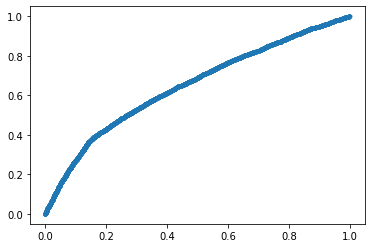

In [4]:
#----------------------------------------------------------------------
#    logistic regression
#----------------------------------------------------------------------
lr = LogisticRegression()

#fit
print('fit')
lr.fit(x_train, y_train)

#pred
print("pred")
pred = lr.predict(x_test)

#score
print("score")
score = lr.score(x_test, y_test)
print(score)

#pred proba
print("pred proba")
pred_prob = lr.predict_proba(x_test)[:,1]
print(pred_prob)

#AUC
fpr, tpr, _ = roc_curve(y_test,pred_prob)
plt.plot(fpr, tpr, marker='.', label='Logistic')

#cross val
#from sklearn.model_selection import cross_val_score
#print(cross_val_score(lr, x_test, y_test))

#rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#print(rmse)

print(confusion_matrix(y_test,pred))
print("AUC: {}".format(roc_auc_score(y_test, pred_prob)))

In [63]:
# commit 0,66283
commit=isTest.loc[:,isTest.columns == 'booking_id']
isTest=isTest.drop(columns=['return90','booking_id'],axis=1)
pred_prob = lr.predict_proba(isTest)[:,1]
print(pred_prob)
commit['return90']=pred_prob
commit.to_csv('result.csv',sep=',',encoding='utf-8',index=False)

[0.44229613 0.42916149 0.33765884 ... 0.16598075 0.12626087 0.11829519]


0.766176545929607
pred proba
[0.5        0.         0.25581395 ... 0.5        1.         0.25      ]
[[14445  1188]
 [ 3376   510]]
AUC: 0.5645858677022316


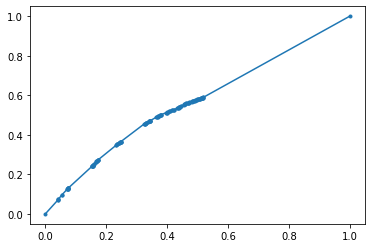

In [10]:
#----------------------------------------------------------------------
#    decision tree
#----------------------------------------------------------------------
clf = tree.DecisionTreeClassifier()

#fit
clf.fit(x_train, y_train)

#pred
pred_clf = clf.predict(x_test)

#score
score = clf.score(x_test, y_test)
print(score)

#pred proba
print("pred proba")
pred_clf_prob = clf.predict_proba(x_test)[:,1]
print(pred_clf_prob)

#Auc
fpr, tpr, _ = roc_curve(y_test,pred_clf_prob)
#rmse = np.sqrt(mean_squared_error(y_test, pred_clf))
#print(rmse)

print(confusion_matrix(y_test,pred_clf))

plt.plot(fpr, tpr, marker='.', label='Logistic')
print("AUC: {}".format(roc_auc_score(y_test, pred_clf_prob)))

In [ ]:
# commit
print(isTest)
pred_prob = clf.predict_proba(isTest)[:,1]
commit=data_Test.loc[:,data_Test.columns == 'booking_id']
print(pred_prob)
commit['return90']=pred_prob
commit.to_csv('result.csv',sep=',',encoding='utf-8',index=False)

/Users/sylvainjiang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sylvainjiang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7992725037143297
pred proba
[0.22916667 0.12762238 0.13043478 ... 0.28341584 0.16892911 0.12762238]
[[15550    83]
 [ 3835    51]]
AUC: 0.5937025873221258


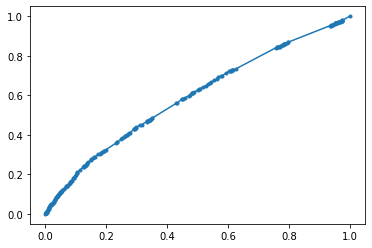

In [6]:
#----------------------------------------------------------------------
#    stacking classifier with decision tree and knn
#----------------------------------------------------------------------
clf_dt = tree.DecisionTreeClassifier(min_samples_leaf = 5, min_samples_split = 15, random_state=500)
clf_lr = neighbors.KNeighborsClassifier(n_neighbors=10,algorithm='auto')

estimators=[('dt',clf_dt),('lr',clf_lr)]

?ensemble.StackingClassifier
clf_stack = ensemble.StackingClassifier(estimators=estimators,final_estimator=tree.DecisionTreeClassifier(),)

#fit
clf_stack.fit(x_train, y_train)

#pred
pred_stack = clf_stack.predict(x_test)

#score
score = clf_stack.score(x_test, y_test)
print(score)

#pred proba
print("pred proba")
pred_stacking_prob = clf_stack.predict_proba(x_test)[:,1]
print(pred_stacking_prob)

#Auc
fpr, tpr, _ = roc_curve(y_test,pred_stacking_prob)
#rmse = np.sqrt(mean_squared_error(y_test, pred_clf))
#print(rmse)

print(confusion_matrix(y_test,pred_stack))

plt.plot(fpr, tpr, marker='.', label='Logistic')
print("AUC: {}".format(roc_auc_score(y_test, pred_stacking_prob)))

/Users/sylvainjiang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sylvainjiang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8009119319637277
pred proba
[0.18387036 0.17335537 0.2369455  ... 0.1822902  0.19980327 0.13159888]
[[15627     6]
 [ 3880     6]]
AUC: 0.600301403272878


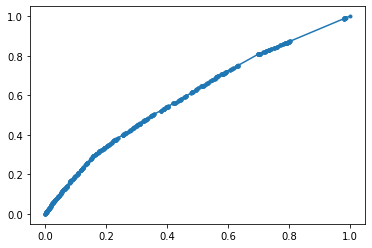

In [7]:
#----------------------------------------------------------------------
#    stacking model with knn,dicision tree, gaussian, lostic regression
#----------------------------------------------------------------------

from sklearn import naive_bayes

# Create the first-layer models
clf_knn = neighbors.KNeighborsClassifier(n_neighbors=5,algorithm='auto')
clf_dt = tree.DecisionTreeClassifier(min_samples_leaf = 5, min_samples_split = 15, random_state=500)
clf_nb = naive_bayes.GaussianNB()

# Create the second-layer model
clf_lr = LogisticRegression()

# stacking model
clf_stack_2 = ensemble.StackingClassifier(estimators=[("knn",clf_knn),("dt",clf_dt),('nb',clf_nb)],final_estimator=clf_lr)

#fit
clf_stack_2.fit(x_train, y_train)

#pred
pred_stack_2 = clf_stack_2.predict(x_test)

#score
score = clf_stack_2.score(x_test, y_test)
print(score)

#pred proba
print("pred proba")
pred_stacking_prob_2 = clf_stack_2.predict_proba(x_test)[:,1]
print(pred_stacking_prob_2)

#Auc
fpr, tpr, _ = roc_curve(y_test,pred_stacking_prob_2)
#rmse = np.sqrt(mean_squared_error(y_test, pred_clf))
#print(rmse)

print(confusion_matrix(y_test,pred_stack_2))

plt.plot(fpr, tpr, marker='.', label='Logistic')
print("AUC: {}".format(roc_auc_score(y_test, pred_stacking_prob_2)))

In [8]:
# commit stacking
commit=isTest.loc[:,isTest.columns == 'booking_id']
isTest=isTest.drop(columns=['return90','booking_id'],axis=1)
pred_prob = clf_stack_2.predict_proba(isTest)[:,1]
print(pred_prob)
commit['return90']=pred_prob
commit.to_csv('result.csv',sep=',',encoding='utf-8',index=False)

[0.19816447 0.1718869  0.24597457 ... 0.26395571 0.18854428 0.13588214]


/Users/sylvainjiang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sylvainjiang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/sylvainjiang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

0.8033198422050309
pred proba
[0.19625197 0.20161236 0.19949558 ... 0.19667569 0.20638604 0.19185275]
[[15680     0]
 [ 3839     0]]
AUC: 0.6456666625689088


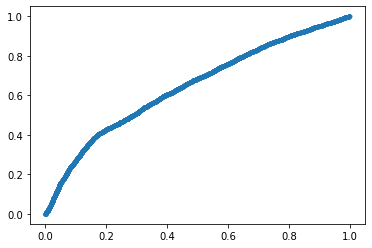

In [12]:
#----------------------------------------------------------------------
#    Bagging
#----------------------------------------------------------------------
clf_base = LogisticRegression()

# bagging
clf_bag = ensemble.BaggingClassifier(base_estimator=clf_base,n_estimators=100,max_features=15, 
                                     max_samples=0.65,bootstrap=True, random_state=500)

#fit
clf_bag.fit(x_train, y_train)

# pred
pred_bag = clf_bag.predict(x_test)

#score
score = clf_bag.score(x_test, y_test)
print(score)

#pred proba
print("pred proba")
pred_bag_prob = clf_bag.predict_proba(x_test)[:,1]
print(pred_bag_prob)

#Auc
fpr, tpr, _ = roc_curve(y_test,pred_bag_prob)
#rmse = np.sqrt(mean_squared_error(y_test, pred_clf))
#print(rmse)

print(confusion_matrix(y_test,pred_bag))

plt.plot(fpr, tpr, marker='.', label='Logistic')
print("AUC: {}".format(roc_auc_score(y_test, pred_bag_prob)))

/Users/sylvainjiang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8030636815410626
pred proba
[0.11417267 0.08189681 0.1507033  ... 0.13473518 0.32741429 0.11396453]
[[15632    48]
 [ 3796    43]]
AUC: 0.6659585131916793


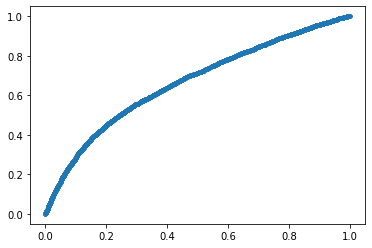

In [10]:
#----------------------------------------------------------------------
#    Boosting
#----------------------------------------------------------------------
clf_boost = ensemble.GradientBoostingClassifier(n_estimators=100,learning_rate=0.1, random_state=500,
                                                loss='exponential',subsample=0.7,max_features='auto')

#fit
clf_boost.fit(x_train, y_train)

# pred
pred_boost = clf_boost.predict(x_test)

#score
score = clf_boost.score(x_test, y_test)
print(score)

#pred proba
print("pred proba")
pred_boost_prob = clf_boost.predict_proba(x_test)[:,1]
print(pred_boost_prob)

#Auc
fpr, tpr, _ = roc_curve(y_test,pred_boost_prob)
#rmse = np.sqrt(mean_squared_error(y_test, pred_clf))
#print(rmse)

print(confusion_matrix(y_test,pred_boost))

plt.plot(fpr, tpr, marker='.', label='Logistic')
print("AUC: {}".format(roc_auc_score(y_test, pred_boost_prob)))

In [11]:
# commit boosting 0.679
commit=isTest.loc[:,isTest.columns == 'booking_id']
isTest=isTest.drop(columns=['return90','booking_id'],axis=1)
pred_prob = clf_boost.predict_proba(isTest)[:,1]
print(pred_prob)
commit['return90']=pred_prob
commit.to_csv('result.csv',sep=',',encoding='utf-8',index=False)

[0.42010206 0.39991029 0.34282657 ... 0.20046069 0.13234014 0.09847991]


/////////////////////////////////////////////
Randomized search..


/Users/sylvainjiang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sylvainjiang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Randomized search time: 184.8004810810089
Best score: 0.7999487661173255
Best params: 
booster: 'gblinear'
colsample_bytree: 0.5
learning_rate: 0.2
max_depth: 3
min_child_weight: 11
missing: -200
n_estimators: 5
n_thread: 5
seed: 2300
silent: 0
subsample: 1
Best estimator
XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5, gamma=None,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=None, max_depth=3,
              min_child_weight=11, missing=-200, monotone_constraints=None,
              n_estimators=5, n_jobs=1, n_thread=5, nthread=1,
              num_parallel_tree=None, objective='binary:logistic',
              random_state=2300, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
              seed=2300, silent=0, subsample=1, tree_method=None,
              validate_parameters=False, ...)
//////////////////////////////////////

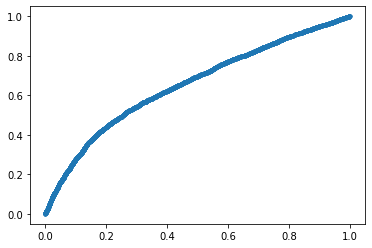

In [54]:
#----------------------------------------------------------------------
#    XGB
#----------------------------------------------------------------------
import time
clf = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',silent=True, nthread=1)

params = {
        'max_depth':[4,3],
        'learning_rate':[0.2],
        'booster':['gblinear'],
        'min_child_weight':[11,15],
        'subsample':[1],
        'silent':[0],
        'n_estimators':[5],
        'missing':[-99,-200,-300],
        'seed':[2431,2300],
        'colsample_bytree':[0.5,0.75,1],
        'n_thread':[5,7],
        }

clf_xgb = RandomizedSearchCV(clf, param_distributions=params, n_iter=10, n_jobs=-1)


print('/////////////////////////////////////////////')

#fit

print("Randomized search..")
search_time_start = time.time()
clf_xgb.fit(x_train, y_train)
print("Randomized search time:", time.time() - search_time_start)

best_score = clf_xgb.best_score_
best_params = clf_xgb.best_params_
best_estimator=clf_xgb.best_estimator_

print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))
print("Best estimator")
print(best_estimator)
print('/////////////////////////////////////////////')

# pred
pred_xgb = clf_xgb.predict(x_test)

#score
score = clf_xgb.score(x_test, y_test)
print(score)

#pred proba
print("pred proba")
pred_xgb_prob = clf_xgb.predict_proba(x_test)[:,1]
print(pred_prob)

#Auc
fpr, tpr, _ = roc_curve(y_test,pred_xgb_prob)
#rmse = np.sqrt(mean_squared_error(y_test, pred_clf))
#print(rmse)

print(confusion_matrix(y_test,pred_xgb))

plt.plot(fpr, tpr, marker='.', label='Logistic')
print("AUC: {}".format(roc_auc_score(y_test, pred_xgb_prob)))

In [65]:
# commit xgb 0,659
commit=isTest.loc[:,isTest.columns == 'booking_id']
isTest=isTest.drop(columns=['return90','booking_id'],axis=1)
pred_prob = clf_xgb.predict_proba(isTest)[:,1]
print(pred_prob)
commit['return90']=pred_prob
commit.to_csv('result.csv',sep=',',encoding='utf-8',index=False)

[0.49316713 0.44624338 0.37973475 ... 0.15987787 0.15613706 0.13355546]


In [66]:
#----------------------------------------------------------------------
#    Boosting
#----------------------------------------------------------------------
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt    

boost = ensemble.GradientBoostingClassifier()
print("////////////////////////////////////")
params = {'learning_rate': sp_randFloat(),
          'subsample'    : sp_randFloat(),
          'n_estimators' : sp_randInt(100, 1000),
          'max_depth'    : sp_randInt(4, 10) 
        
         }
print("////////////////////////////////////")

clf_boost = RandomizedSearchCV(boost, param_distributions=params, n_iter=10, n_jobs=-1)

print("////////////////////////////////////")

#fit
clf_boost.fit(x_train, y_train)
print("////////////////////////////////////")

# pred
pred_boost = clf_boost.predict(x_test)

#score
score = clf_boost.score(x_test, y_test)
print(score)

#pred proba
print("pred proba")
pred_boost_prob = clf_boost.predict_proba(x_test)[:,1]
print(pred_boost_prob)

#Auc
fpr, tpr, _ = roc_curve(y_test,pred_boost_prob)
#rmse = np.sqrt(mean_squared_error(y_test, pred_clf))
#print(rmse)

print(confusion_matrix(y_test,pred_boost))

plt.plot(fpr, tpr, marker='.', label='Logistic')
print("AUC: {}".format(roc_auc_score(y_test, pred_boost_prob)))

////////////////////////////////////
////////////////////////////////////
////////////////////////////////////


KeyboardInterrupt: 